미세먼지(PM10) 예측 예제

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [3]:
# 폰트지정
plt.rcParams["font.family"] = "NanumGothic"

# 마이너스 부호 깨짐 지정
plt.rcParams["axes.unicode_minus"] = False

# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = "{:.2f}".format

In [4]:
# 데이터 로드
file_path = "../dataset/seoul_pm10.csv" # 데이터 파일 경로
df = pd.read_csv(file_path, encoding="cp949")

In [5]:
print("데이터 크기:", df.shape)
print("\n처음 5개 행:")
display(df.head())

데이터 크기: (227759, 4)

처음 5개 행:


,date,area,pm10,pm2.5
0,2022-12-31 23:00,강남구,57.00,44.00
1,2022-12-31 23:00,강동구,68.00,55.00
2,2022-12-31 23:00,강북구,59.00,42.00
3,2022-12-31 23:00,강서구,62.00,40.00
4,2022-12-31 23:00,관악구,57.00,38.00


In [6]:
# 기본 데이터 정보 확인
print("\n데이터 기간:", df["date"].min(), "~", df["date"].max)
print("총 관측 수:", len(df))
print("지역 수:", df["area"].nunique())
print("\n결측치 개수:")
display(df.isnull().sum())


데이터 기간: 2022-01-01 0:00 ~ <bound method Series.max of 0         2022-12-31 23:00
1         2022-12-31 23:00
2         2022-12-31 23:00
3         2022-12-31 23:00
4         2022-12-31 23:00
                ...       
227754     2022-01-01 0:00
227755     2022-01-01 0:00
227756     2022-01-01 0:00
227757     2022-01-01 0:00
227758     2022-01-01 0:00
Name: date, Length: 227759, dtype: object>
총 관측 수: 227759
지역 수: 26

결측치 개수:


date        0
area        0
pm10     4916
pm2.5    4247
dtype: int64

In [7]:
# 데이터 전처리
# 날짜 변환
df["date"] = pd.to_datetime(df['date'])

In [8]:
# 결측치 처리
df["pm10"] = df["pm10"].fillna(df["pm10"].mean()) # 결측치를 평균 값으로 채우겠다
df["pm2.5"] = df["pm2.5"].fillna(df["pm2.5"].mean())

In [9]:
# 시간 관련 피처(column) 추가
df["hour"] = df["date"].dt.hour
df["day_of_week"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month

In [10]:
# 지역 원-핫 인코딩
df_encoded = pd.get_dummies(df, columns=["area"], prefix="area")

In [11]:
# 전처리된 데이터 확인
print("\n전처리된 데이터 샘플:")
display(df_encoded.head())


전처리된 데이터 샘플:


,date,pm10,pm2.5,hour,day_of_week,month,area_강남구,area_강동구,area_강북구,area_강서구,...,area_성북구,area_송파구,area_양천구,area_영등포구,area_용산구,area_은평구,area_종로구,area_중구,area_중랑구,area_평균
0,2022-12-31 23:00:00,57.00,44.00,23,5,12,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2022-12-31 23:00:00,68.00,55.00,23,5,12,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2022-12-31 23:00:00,59.00,42.00,23,5,12,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,2022-12-31 23:00:00,62.00,40.00,23,5,12,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,2022-12-31 23:00:00,57.00,38.00,23,5,12,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [12]:
# PM10 모델 학습
features_pm10 = ["pm2.5", "hour", "day_of_week", "month"] + [col for col in df_encoded.columns if col.startswith("area")]
X_pm10 = df_encoded[features_pm10]
y_pm10 = df_encoded["pm10"]

In [13]:
# PM2.5 모델 학습
features_pm25 = ["pm10", "hour", "day_of_week", "month"] + [col for col in df_encoded.columns if col.startswith("area_")]
X_pm25 = df_encoded[features_pm25]
y_pm25 = df_encoded["pm2.5"]

In [14]:
# 데이터 분할
X_train_pm10, X_test_pm10, y_train_pm10, y_test_pm10 = train_test_split(X_pm10, y_pm10, test_size=0.2, random_state=42)
X_train_pm25, X_test_pm25, y_train_pm25, y_test_pm25 = train_test_split(X_pm25, y_pm25, test_size=0.2, random_state=42)

In [15]:
# 모델 학습
model_pm10 = LinearRegression()
model_pm25 = LinearRegression()

In [16]:
model_pm10.fit(X_train_pm10, y_train_pm10)
model_pm25.fit(X_train_pm25, y_train_pm25)

LinearRegression()

In [17]:
# 모델 예측
y_pred_pm10 = model_pm10.predict(X_test_pm10)
y_pred_pm25 = model_pm25.predict(X_test_pm25)

In [18]:
# 모델 평가가
print("\nPM10 모델 성능")
print(f"R2 Score: {r2_score(y_test_pm10, y_pred_pm10):.4f}")
print(f"MSE: {mean_squared_error(y_test_pm10, y_pred_pm10):.4f}")


PM10 모델 성능
R2 Score: 0.6079
MSE: 198.3575


In [19]:
print("\nPM25 모델 성능")
print(f"R2 Score: {r2_score(y_test_pm25, y_pred_pm25):.4f}")
print(f"MSE: {mean_squared_error(y_test_pm25, y_pred_pm25):.4f}")


PM25 모델 성능
R2 Score: 0.6136
MSE: 73.9499


In [50]:
# 2023년 1월 1일 예측을 위한 함수
def create_prediction_data(area):
    predictions = []
    for hour in range(24):
        pred_data = {
            "hour" : hour,
            "day_of_week" : 6, # 2023년 1월 1일은 일요일
            "month" : 1
        }

        # 지역 원-핫 인코딩 추가
        for area_col in [col for col in df_encoded.columns if col.startswith("area_")]:
            pred_data[area_col] = 1 if area_col == f"area_{area}" else 0
        
        predictions.append(pred_data)

    return pd.DataFrame(predictions)

In [51]:
# 사용자 입력 - 지연 선택
areas = sorted(df["area"].unique())
print("\n예측 가능한 지역:")
display(areas)


예측 가능한 지역:


['강남구',
 '강동구',
 '강북구',
 '강서구',
 '관악구',
 '광진구',
 '구로구',
 '금천구',
 '노원구',
 '도봉구',
 '동대문구',
 '동작구',
 '마포구',
 '서대문구',
 '서초구',
 '성동구',
 '성북구',
 '송파구',
 '양천구',
 '영등포구',
 '용산구',
 '은평구',
 '종로구',
 '중구',
 '중랑구',
 '평균']

In [52]:
# 예시로 한 지역 선택(실제로는 사용자가 선택)
selected_area = areas[0] # 첫 번째 지역 선택
print(f"\n선택된 지역: {selected_area}")


선택된 지역: 강남구


In [53]:
# 2023년 1월 1일 예측
future_data = create_prediction_data(selected_area)
pm10_predictions = []
pm25_predictions = []

In [54]:
# 반복 예측(PM10과 PM2.5 상호 의존성 처리)
for hour in range(24):
    hour_data = future_data.iloc[[hour]].copy()

    # 초기값 설정
    hour_data["pm2.5"] = df["pm2.5"].mean()
    hour_data["pm10"] = df["pm10"].mean()

    # 반복 예측으로 정확도 향상
    for _ in range(3):
        pm10_pred = model_pm10.predict(hour_data[features_pm10])
        pm25_pred = model_pm25.predict(hour_data[features_pm25])

        hour_data["pm10"] = pm10_pred
        hour_data["pm2.5"] = pm25_pred

    pm10_predictions.append(pm10_pred[0])
    pm25_predictions.append(pm25_pred[0])



In [55]:
# 예측 결과 시각화
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

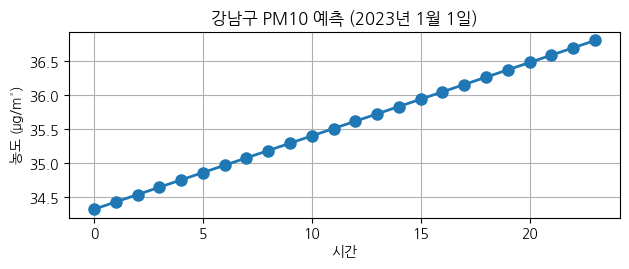

In [56]:
# PM10 그래프
plt.subplot(2, 1, 1)
plt.plot(range(24), pm10_predictions, marker='o', linewidth=2, markersize=8)
plt.title(f'{selected_area} PM10 예측 (2023년 1월 1일)')
plt.xlabel('시간')
plt.ylabel('농도 (μg/m³)')
plt.grid(True)
plt.tight_layout()
plt.show()

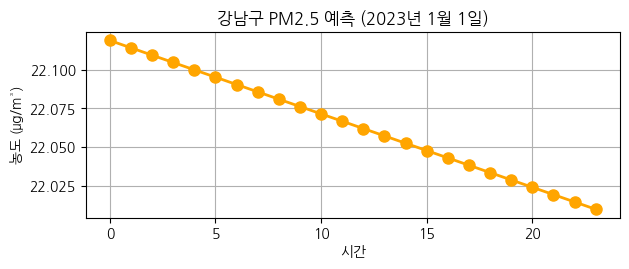

In [57]:
# PM2.5 그래프
plt.subplot(2, 1, 2)
plt.plot(range(24), pm25_predictions, marker='o', linewidth=2, markersize=8, color='orange')
plt.title(f'{selected_area} PM2.5 예측 (2023년 1월 1일)')
plt.xlabel('시간')
plt.ylabel('농도 (μg/m³)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# 예측 결과 통계
print("\nPM10 예측 통계:")
print(f"평균: {np.mean(pm10_predictions):.1f} μg/m³")
print(f"최대: {np.max(pm10_predictions):.1f} μg/m³")
print(f"최소: {np.min(pm10_predictions):.1f} μg/m³")


PM10 예측 통계:
평균: 35.6 μg/m³
최대: 36.8 μg/m³
최소: 34.3 μg/m³


In [28]:
print("\nPM2.5 예측 통계:")
print(f"평균: {np.mean(pm25_predictions):.1f} μg/m³")
print(f"최대: {np.max(pm25_predictions):.1f} μg/m³")
print(f"최소: {np.min(pm25_predictions):.1f} μg/m³")


PM2.5 예측 통계:
평균: 22.1 μg/m³
최대: 22.1 μg/m³
최소: 22.0 μg/m³


In [29]:
# 시간별 예측값 데이터프레임 생성
hourly_predictions = pd.DataFrame({
    '시간': range(24),
    'PM10': [f"{x:.1f}" for x in pm10_predictions],
    'PM2.5': [f"{x:.1f}" for x in pm25_predictions]
})

In [30]:
print("\n시간별 예측값:")
display(hourly_predictions)


시간별 예측값:


,시간,PM10,PM2.5
0,0,34.3,22.1
1,1,34.4,22.1
2,2,34.5,22.1
3,3,34.6,22.1
4,4,34.8,22.1
5,5,34.9,22.1
6,6,35.0,22.1
7,7,35.1,22.1
8,8,35.2,22.1
9,9,35.3,22.1


In [32]:
# 실제값과 예측값 비교 시각화(테스트 데이터 기준)
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
C:\Users\human-08\AppData\Local\Temp\ipykernel_12940\388940507.py:9: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\human-08\AppData\Local\Temp\ipykernel_12940\388940507.py:9: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'Nanum Gothic' not found.
C:\Users\human-08\AppData\Local\Temp\ipykernel_12940\388940507.py:9: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\human-08\AppData\Local\Temp\ipykernel_12940\388940507.py:9: UserWarning: Glyph 52769

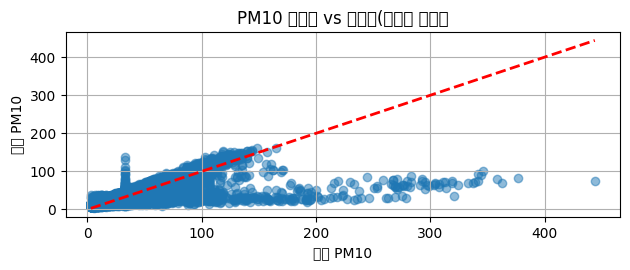

In [33]:
# PM10 비교
plt.subplot(2, 1, 1)
plt.scatter(y_test_pm10, y_pred_pm10, alpha=0.5)
plt.plot([y_test_pm10.min(), y_test_pm10.max()], [y_test_pm10.min(), y_test_pm10.max()], "r--", lw=2)
plt.xlabel("실제 PM10")
plt.ylabel("예측 PM10")
plt.title("PM10 실제값 vs 예측값(테스트 데이터")
plt.grid(True)
plt.tight_layout()
plt.show()

findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
C:\Users\human-08\AppData\Local\Temp\ipykernel_12940\2236336396.py:11: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\human-08\AppData\Local\Temp\ipykernel_12940\2236336396.py:11: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
C:\Users\human-08\AppDa

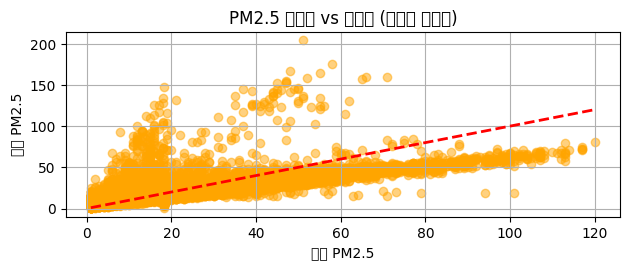

In [34]:
# PM2.5 비교
plt.subplot(2, 1, 2)
plt.scatter(y_test_pm25, y_pred_pm25, alpha=0.5, color='orange')
plt.plot([y_test_pm25.min(), y_test_pm25.max()],
         [y_test_pm25.min(), y_test_pm25.max()],
         'r--', lw=2)
plt.xlabel('실제 PM2.5')
plt.ylabel('예측 PM2.5')
plt.title('PM2.5 실제값 vs 예측값 (테스트 데이터)')
plt.grid(True)
plt.tight_layout()
plt.show()